In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

In [2]:
plt.rcParams.update({'font.size': 25})
pd.set_option("display.max_columns", None)

In [3]:
path_to_data_train = Path.cwd() / ".." / "data" / "final" / "images" / "train" / "objects_results.csv"
path_to_data_test = Path.cwd() / ".." / "data" / "final" / "images" / "test" / "objects_results.csv"
path_to_resolution_train = Path.cwd() / ".." / "data" / "final" / "images" / "train" / "nifti_resolution.csv"
path_to_resolution_test = Path.cwd() / ".." / "data" / "final" / "images" / "test" / "nifti_resolution.csv"
path_to_image_stats_train = Path.cwd() / "resources" / "intensity_stats_train.csv"
path_to_image_stats_test = Path.cwd() / "resources" / "intensity_stats_test.csv"
path_to_image_densities_train = Path.cwd() / "resources" / "densities_train.npy"
path_to_image_densities_test = Path.cwd() / "resources" / "densities_test.npy"
path_to_patients = Path.cwd() / ".." / "data" / "final" / "metadata" / "patients.csv"
path_to_series = Path.cwd() / ".." / "data" / "final" / "metadata" / "series.json"
linewidth_boxplot = 5
savefig = True
add_title = False
savecsv = True

In [4]:
# Concatenate train and test files
objects_df = pd.DataFrame()
for path, subset_name in [(path_to_data_train, 'train'), (path_to_data_test, 'test')]:
    subset_df = pd.read_csv(path)
    subset_df['subset'] = subset_name
    objects_df = pd.concat(
        [objects_df, subset_df],
        ignore_index=True
    )
objects_df.rename(columns={"label_description_en": "label_description"}, inplace=True)
objects_df['lesion_type'] = objects_df['label_description'].apply(lambda x: x.split(',')[0])
objects_df['lesion_location'] = objects_df['label_description'].apply(lambda x: x.split(',')[1])

In [5]:
# Normalize label descriptions
def normalize_label_description(row):
    return ','.join([value.lower().strip() for value in row['label_description'].split(',')])

objects_df['label_description'] = objects_df.apply(
    lambda row: normalize_label_description(row),
    axis=1
)

In [6]:
# Add patient information
def add_patient_info(objects_df, path_to_patients, path_to_series):
    output_df = objects_df.copy()
    output_df['uuid'] = output_df['filename'].apply(lambda x: x.split('.nii.gz')[0])
    with open(path_to_series, 'r') as file:
        series_df = pd.DataFrame(json.load(file))
    series_df.rename(columns={"name": "series_name"}, inplace=True)
    output_df = output_df.merge(
        series_df[['series_name', 'uuid', 'patient_id', 'patient_code', 'study_date', 'study_uuid']],
        on='uuid',
        how='left'
    )
    patients_df = pd.read_csv(path_to_patients)
    patients_columns_to_drop = [
        'patient_code'
    ]
    patients_df.drop(columns=patients_columns_to_drop, inplace=True)
    output_df = output_df.merge(
        patients_df,
        on='patient_id',
        how='left'
    )
    output_df.sort_values(
        by=[
            'filename',
            'study_date',
            'label_value'
        ],
        inplace=True
    )
    return output_df
objects_df = add_patient_info(objects_df, path_to_patients, path_to_series)
objects_df['series_region'] = objects_df['series_name'].apply(lambda x: "Thorax" if x.split()[0] == "Torax" else "Abdomen")
all_objects_df = objects_df.copy()

In [7]:
# Get included series
def get_series_df(path_to_train_csv, path_to_test_csv, path_to_series):
    with open(path_to_series, 'r') as file:
        series_df = pd.DataFrame(json.load(file))
    series_df.drop(
        columns=[
            'rows',
            'columns',
            'slices',
            'row_spacing',
            'column_spacing'
        ],
        inplace=True
    )
    df = pd.DataFrame()
    for subset, path in [('train', path_to_train_csv), ('test', path_to_test_csv)]:
        df = pd.concat([df, pd.read_csv(path)], ignore_index=True)
        df['uuid'] = df['filename'].apply(lambda x: x.split('.nii.gz')[0])
        df['subset'] = subset
    series_df = series_df.merge(
        df,
        on='uuid',
        how='right'
    )
    series_df['series_region'] = series_df['name'].apply(lambda x: "Thorax" if x.split()[0] == "Torax" else "Abdomen")
    return series_df
series_df = get_series_df(path_to_resolution_train, path_to_resolution_test, path_to_series)

In [8]:
# Stats of removed lesions size
print(f"original objects count: {len(all_objects_df)}")
removed_df = all_objects_df[all_objects_df['removed'] == True].copy()
objects_df = all_objects_df[all_objects_df['removed'] == False].copy()
if savecsv:
    objects_df.to_csv(Path.cwd() / 'results' / 'lesions_all.csv', index=False)
print(f"removed objects with volume < 50 voxels: {len(removed_df[removed_df['size_voxels'] < 50])}")
print(f"removed objects with n_slices == 1: {len(removed_df[removed_df['slices_count'] == 1])}")
print(f"total removed objects: {len(removed_df)}")
print(f"final objects count: {len(objects_df)}")
total_lesions_count_final = len(objects_df)
if savecsv:
    objects_df.to_csv(Path.cwd() / 'results' / 'lesions_final.csv', index=False)

original objects count: 1552
removed objects with volume < 50 voxels: 291
removed objects with n_slices == 1: 302
total removed objects: 324
final objects count: 1228


In [9]:
# distribution of patients for each cancer type
grouped = objects_df.groupby(['diagnosis'])['patient_id'].nunique().reset_index(name="patients_count").sort_values(by="patients_count", ascending=False)
total_patients_count = grouped['patients_count'].sum()
display(grouped)

,diagnosis,patients_count
2,colon cancer,5
4,gastric cancer,5
5,lung cancer,4
3,gallbladder cancer,2
8,rectal cancer,2
0,bladder cancer,1
1,breast cancer,1
6,melanoma,1
7,ovarian cancer,1


,patient_id,protocol,sex,age,diagnosis,subset
1056,10,IE 26/17,M,67,melanoma,test
0,12,1029/19,F,56,breast cancer,train
1059,15,1060/21,M,64,bladder cancer,test
345,22,1029/19,M,64,colon cancer,train
355,24,1029/19,F,75,gastric cancer,train
1068,18,1029/19,M,65,colon cancer,test
1075,28,1029/19,F,37,colon cancer,test
631,7,1029/19,M,53,rectal cancer,train
637,5,1029/19,F,59,colon cancer,train
1428,13,1029/19,M,58,gastric cancer,test


Age statistics
--------------------


count    22.000000
mean     62.318182
std       8.385852
min      37.000000
25%      58.250000
50%      64.000000
75%      67.750000
max      75.000000
Name: age, dtype: float64

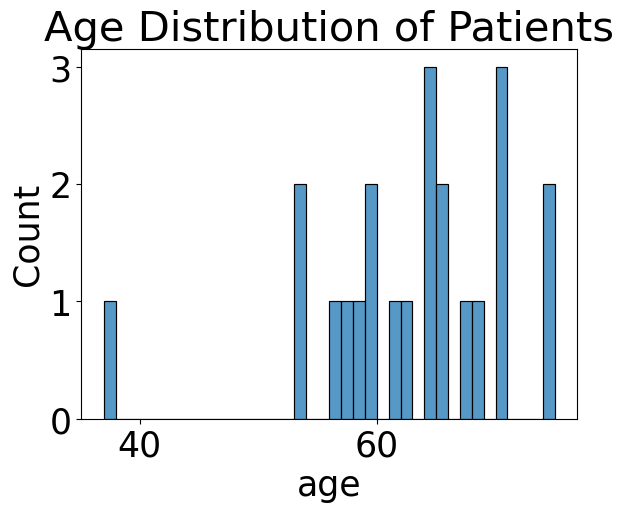

sex
M    11
F    11
Name: count, dtype: int64

subset
train    14
test      8
Name: count, dtype: int64

In [10]:
# Distribution of age, sex and healthcate insurance
patient_columns = ['patient_id', 'protocol', 'sex', 'age', 'diagnosis', 'subset']
patients = objects_df.drop_duplicates(subset="patient_id")[patient_columns]
display(patients)
# age
print("Age statistics")
print(20 * '-')
display(patients['age'].describe())
sns.histplot(data=patients, x='age', binwidth=1)
plt.title('Age Distribution of Patients')
plt.show()
# sex
counts = patients['sex'].value_counts()
display(counts)
# Subset
print('\n')
counts = patients['subset'].value_counts()
display(counts)

In [11]:
# Studies per patients and total studies
grouped = objects_df.groupby(['subset', 'patient_id', 'diagnosis'])['study_uuid'].nunique().reset_index(name="studies_count")
total_studies_count = grouped['studies_count'].sum()
display(grouped)
print(f"total studies: {total_studies_count}")
print(f"min date: {objects_df['study_date'].min()}")
print(f"max date: {objects_df['study_date'].max()}")

,subset,patient_id,diagnosis,studies_count
0,test,3,gallbladder cancer,3
1,test,10,melanoma,1
2,test,13,gastric cancer,3
3,test,15,bladder cancer,3
4,test,18,colon cancer,1
5,test,28,colon cancer,2
6,test,30,rectal cancer,3
7,test,35,gastric cancer,2
8,train,1,lung cancer,1
9,train,2,gastric cancer,1


total studies: 48
min date: 20171215
max date: 20231017


In [12]:
# CT images for thorax and abdomen
grouped = objects_df.groupby(['series_region'])['filename'].nunique().reset_index(name="images_count")
total_ct_images_count = grouped["images_count"].sum()
display(grouped)

,series_region,images_count
0,Abdomen,36
1,Thorax,22


In [13]:
# Distribution by lesion type (primary, metastases, adenopathy)
grouped = objects_df.groupby('lesion_type').size().reset_index(name='lesions_count')
display(grouped)

,lesion_type,lesions_count
0,m,1133
1,n,90
2,t,5


In [14]:
# Summary
print('Summary')
print(30 * '-')
print(f"patients: {total_patients_count}")
print(f"studies: {total_studies_count}")
print(f"CT images (series): {total_ct_images_count}")
print(f"lesions: {total_lesions_count_final}")

Summary
------------------------------
patients: 22
studies: 48
CT images (series): 58
lesions: 1228


In [15]:
plt.rcParams.update({'font.size': 16}) # 25 for histograms and boxplots, 16 for bars

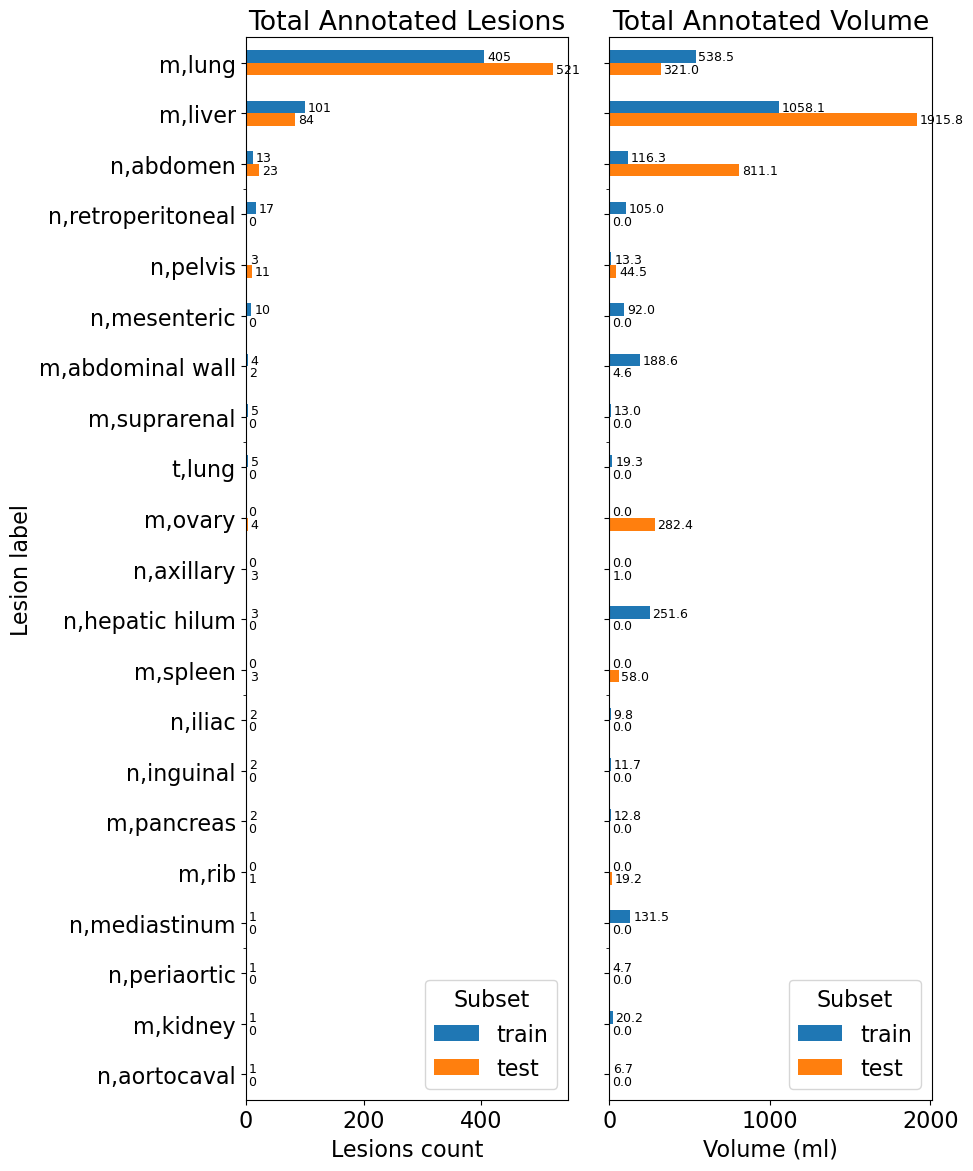

In [16]:
# Horizontal barplots for annotated lesions and annotated volume
_, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 12))
count_grouped = objects_df.groupby(['label_description', 'subset']).size().unstack(fill_value=0)
count_grouped['total'] = count_grouped.sum(axis=1)
count_grouped.sort_values(by='total', inplace=True)
volume_grouped = objects_df.groupby(['label_description', 'subset'])['volume_ml'].sum().unstack(fill_value=0)
volume_grouped['total'] = volume_grouped.sum(axis=1)
for idx, (ax, grouped) in enumerate(zip(axes, [count_grouped, volume_grouped])):
    grouped = grouped.reindex(count_grouped.index)
    grouped[['test', 'train']].plot(
        kind='barh',
        stacked=False,
        color=[plt.cm.tab10.colors[1], plt.cm.tab10.colors[0]],
        ax=ax
    )
    for p in ax.patches:
        left, bottom, width, height = p.get_bbox().bounds
        text = f'{int(width)}' if idx == 0 else f'{width:.1f}'
        ax.annotate(text, xy=(left + width, bottom + height / 2), xytext=(2.0, -0.25), 
                    textcoords='offset points', ha='left', va='center', fontsize=9)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(list(reversed(handles)), list(reversed(labels)), title='Subset', loc='lower right')
axes[0].set_xlabel('Lesions count')
axes[1].set_xlabel('Volume (ml)')
axes[0].set_title('Total Annotated Lesions')
axes[1].set_title('Total Annotated Volume')
axes[0].set_ylabel('Lesion label')
plt.tight_layout()
if savefig:
    plt.savefig(Path.cwd() / 'results' / 'lesions_count_by_label_and_subset_subplots.png', transparent=True)
plt.show()

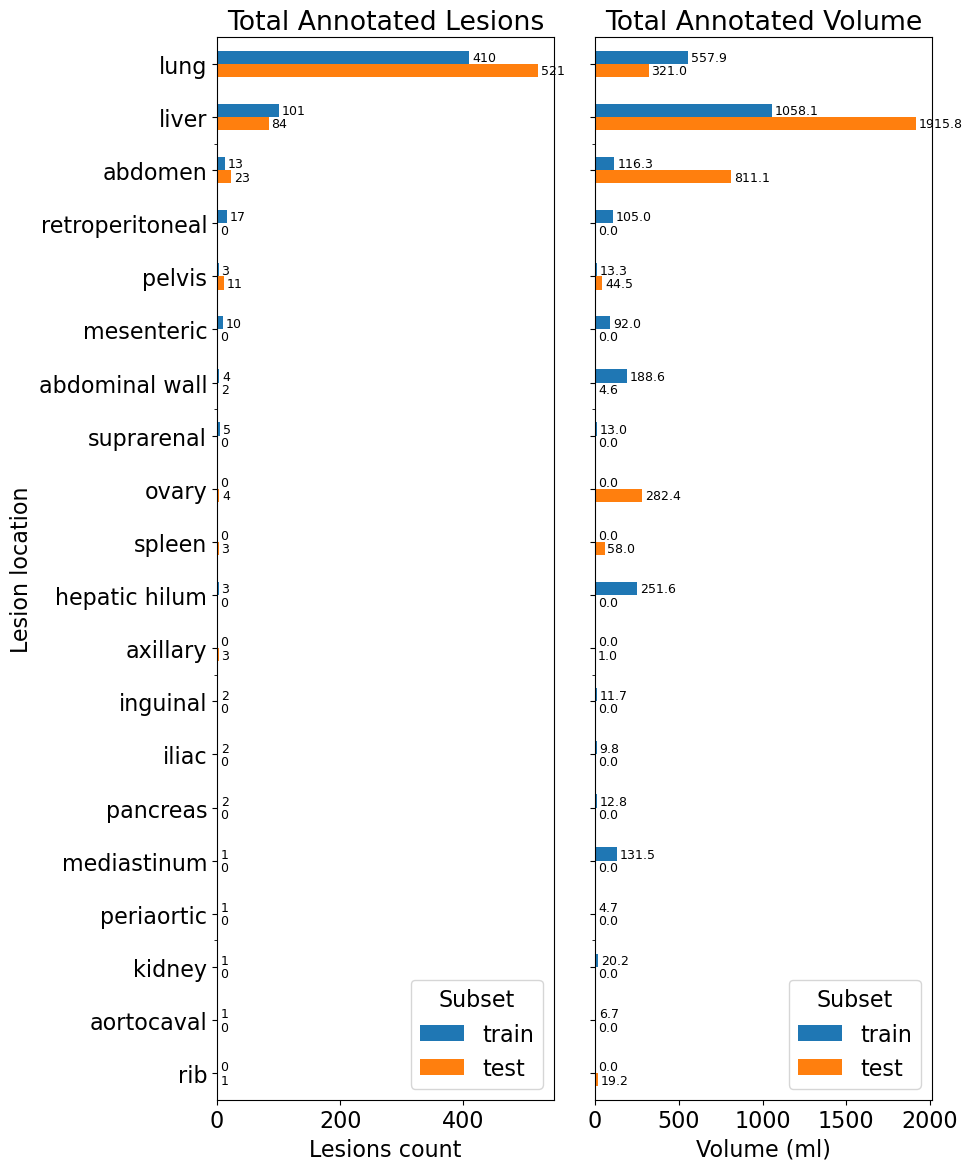

In [17]:
# Horizontal barplots for annotated lesions and annotated volume gruped by lesion location
_, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 12))
count_grouped = objects_df.groupby(['lesion_location', 'subset']).size().unstack(fill_value=0)
count_grouped['total'] = count_grouped.sum(axis=1)
count_grouped.sort_values(by='total', inplace=True)
volume_grouped = objects_df.groupby(['lesion_location', 'subset'])['volume_ml'].sum().unstack(fill_value=0)
volume_grouped['total'] = volume_grouped.sum(axis=1)
for idx, (ax, grouped) in enumerate(zip(axes, [count_grouped, volume_grouped])):
    grouped = grouped.reindex(count_grouped.index)
    grouped[['test', 'train']].plot(
        kind='barh',
        stacked=False,
        color=[plt.cm.tab10.colors[1], plt.cm.tab10.colors[0]],
        ax=ax
    )
    for p in ax.patches:
        left, bottom, width, height = p.get_bbox().bounds
        text = f'{int(width)}' if idx == 0 else f'{width:.1f}'
        ax.annotate(text, xy=(left + width, bottom + height / 2), xytext=(2.0, -0.25), 
                    textcoords='offset points', ha='left', va='center', fontsize=9)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(list(reversed(handles)), list(reversed(labels)), title='Subset', loc='lower right')
axes[0].set_xlabel('Lesions count')
axes[1].set_xlabel('Volume (ml)')
axes[0].set_title('Total Annotated Lesions')
axes[1].set_title('Total Annotated Volume')
axes[0].set_ylabel('Lesion location')
plt.tight_layout()
if savefig:
    plt.savefig(Path.cwd() / 'results' / 'lesions_count_by_location_and_subset_subplots.svg', transparent=True)
plt.show()

In [18]:
# Lesions count grouped by patient
patient_columns = ['subset', 'patient_id', 'diagnosis']
grouped = objects_df.groupby(patient_columns).size().reset_index(name="lesions_count")
grouped = grouped.merge(
    objects_df.groupby(patient_columns)['volume_ml'].sum().reset_index(name="annotated_volume_ml"),
    on=patient_columns,
    how='left'
)
display(grouped)

,subset,patient_id,diagnosis,lesions_count,annotated_volume_ml
0,test,3,gallbladder cancer,8,704.901851
1,test,10,melanoma,3,1.047127
2,test,13,gastric cancer,6,716.585299
3,test,15,bladder cancer,9,26.675090
4,test,18,colon cancer,7,82.795987
5,test,28,colon cancer,574,1601.848634
6,test,30,rectal cancer,39,36.760309
7,test,35,gastric cancer,6,287.051530
8,train,1,lung cancer,3,154.148694
9,train,2,gastric cancer,3,13.896270


In [19]:
# Lesions labels for each patient
columns = ['subset', 'patient_id', 'diagnosis', 'label_description']
grouped = objects_df.groupby(columns).size().reset_index(name='lesions_count')
display(grouped)

,subset,patient_id,diagnosis,label_description,lesions_count
0,test,3,gallbladder cancer,"n,abdomen",8
1,test,10,melanoma,"n,axillary",3
2,test,13,gastric cancer,"m,liver",6
3,test,15,bladder cancer,"n,pelvis",9
4,test,18,colon cancer,"n,abdomen",7
5,test,28,colon cancer,"m,liver",78
6,test,28,colon cancer,"m,lung",482
7,test,28,colon cancer,"m,rib",1
8,test,28,colon cancer,"m,spleen",3
9,test,28,colon cancer,"n,abdomen",8


In [20]:
# Patients count for each lesion label
grouped = objects_df.groupby('label_description')['patient_id'].nunique().reset_index(name="patients_count").sort_values(by='patients_count', ascending=False)
display(grouped)

,label_description,patients_count
2,"m,liver",9
3,"m,lung",9
9,"n,abdomen",7
19,"n,retroperitoneal",3
17,"n,pelvis",3
0,"m,abdominal wall",2
8,"m,suprarenal",2
16,"n,mesenteric",2
20,"t,lung",2
7,"m,spleen",1


In [21]:
# Sex distribution by lesion type
columns = ['label_description', 'patient_id', 'protocol', 'sex', 'age', 'diagnosis']
grouped = objects_df.drop_duplicates(subset=['label_description', 'patient_id'], ignore_index=True)[columns].sort_values(by='label_description')
grouped = grouped.groupby(['label_description', 'sex']).size().unstack(fill_value=0)
display(grouped)

sex,F,M
label_description,,
"m,abdominal wall",2,0
"m,kidney",0,1
"m,liver",5,4
"m,lung",4,5
"m,ovary",1,0
"m,pancreas",0,1
"m,rib",1,0
"m,spleen",1,0
"m,suprarenal",1,1


In [22]:
# Images (series) for each lesion location
grouped = objects_df.groupby('lesion_location')['filename'].nunique().reset_index(name="series_count").sort_values(by='series_count', ascending=False)
display(grouped)

,lesion_location,series_count
8,liver,21
9,lung,21
0,abdomen,13
16,retroperitoneal,6
14,pelvis,5
1,abdominal wall,5
11,mesenteric,4
19,suprarenal,4
4,hepatic hilum,3
12,ovary,2


In [23]:
plt.rcParams.update({'font.size': 25}) # 25 for histograms and boxplots, 16 for bars

pixel size stats
------------------------------


count    58.000000
mean      0.666656
std       0.071892
min       0.525391
25%       0.614258
50%       0.672851
75%       0.712403
max       0.828125
Name: row_spacing_mm, dtype: float64

,count,mean,std,min,25%,50%,75%,max
series_region,,,,,,,,
Abdomen,36.0,0.700901,0.057134,0.591797,0.669922,0.703125,0.742188,0.828125
Thorax,22.0,0.610618,0.057342,0.525391,0.574219,0.607422,0.626465,0.740234


slices count stats
------------------------------


count     58.000000
mean     238.241379
std       79.581650
min       97.000000
25%      177.500000
50%      197.000000
75%      317.000000
max      389.000000
Name: slices, dtype: float64

,count,mean,std,min,25%,50%,75%,max
series_region,,,,,,,,
Abdomen,36.0,182.805556,21.898231,97.0,172.25,184.5,196.0,218.0
Thorax,22.0,328.954545,50.020450,150.0,315.50,335.0,358.0,389.0


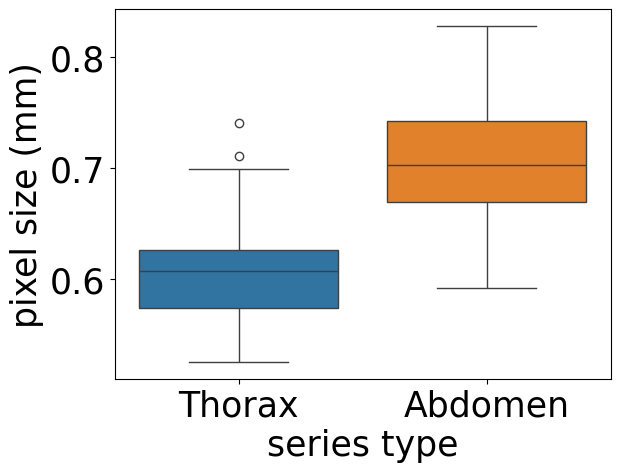

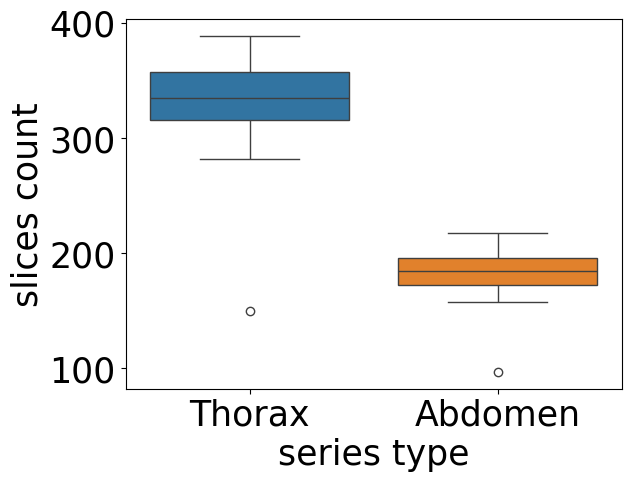

In [24]:
# Resolution information
print("pixel size stats")
print(30 * "-")
display(series_df['row_spacing_mm'].describe())
display(series_df.groupby('series_region')['row_spacing_mm'].describe())
print("slices count stats")
print(30 * "-")
display(series_df['slices'].describe())
display(series_df.groupby('series_region')['slices'].describe())
# Plot pixel spacing
sns.boxplot(
    data=series_df,
    x='series_region',
    y='row_spacing_mm',
    hue='series_region',
    legend=False
)
plt.title('Pixel spacing boxplot')
plt.xlabel('series type')
plt.ylabel('pixel size (mm)')
if savefig:
    if not add_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'pixel_spacing_grouped.svg', bbox_inches='tight', transparent=True)
plt.show()
# Plot slices count
sns.boxplot(
    data=series_df,
    x='series_region',
    y='slices',
    hue='series_region',
    legend=False
)
plt.title('Slices count boxplot')
plt.xlabel('series type')
plt.ylabel('slices count')
if savefig:
    if not add_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'slices_count_grouped.svg', bbox_inches='tight', transparent=True)
plt.show()

In [36]:
plt.rcParams.update({'font.size': 16}) # 25 for histograms and boxplots, 16 for bars

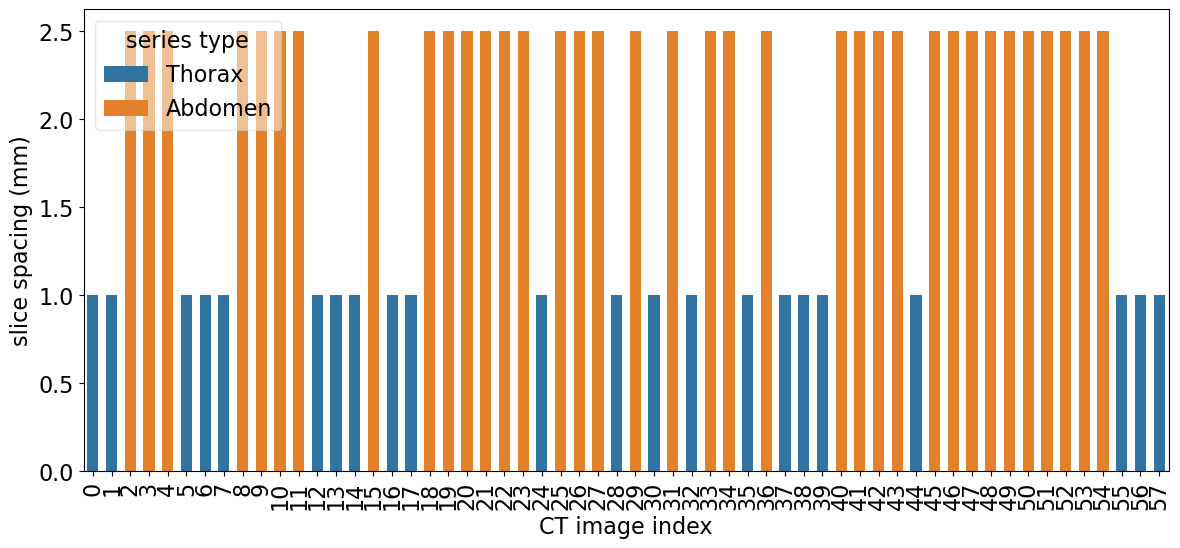

In [38]:
# Plot Slice Thickness
plt.figure(figsize=(14,6))
sns.barplot(data=series_df, x=series_df.index, y='slice_spacing_mm', hue='series_region', dodge=False, width=0.6)
plt.xticks(rotation=90)
plt.legend(title='series type', framealpha=0.5)
plt.xlabel('CT image index')
plt.ylabel('slice spacing (mm)')
plt.title('Slice spacing for each CT image')
if savefig:
    if not add_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'slice_spacing_grouped.svg', bbox_inches='tight', transparent=True)
plt.show()

In [27]:
# Image intensity stats
stats_df = pd.DataFrame()
for subset, path in [('train', path_to_image_stats_train), ('test', path_to_image_stats_test)]:
    df = pd.read_csv(path)
    df['subset'] = subset
    stats_df = pd.concat([stats_df, df], ignore_index=True)
stats_df['uuid'] = stats_df["filename"].apply(lambda x: x.split('.nii.gz')[0])
stats_df = stats_df.merge(
    series_df[['uuid', 'series_region']],
    on='uuid',
    how='left'
)
display(stats_df.groupby('series_region').describe())

slices                                                      \
               count        mean        std    min     25%    50%    75%   
series_region                                                              
Abdomen         36.0  182.805556  21.898231   97.0  172.25  184.5  196.0   
Thorax          22.0  328.954545  50.020450  150.0  315.50  335.0  358.0   

                      rows                                                 \
                 max count   mean  std    min    25%    50%    75%    max   
series_region                                                               
Abdomen        218.0  36.0  512.0  0.0  512.0  512.0  512.0  512.0  512.0   
Thorax         389.0  22.0  512.0  0.0  512.0  512.0  512.0  512.0  512.0   

              columns                                                 mean  \
                count   mean  std    min    25%    50%    75%    max count   
series_region                                                                
Abdomen          36.0  512.0  0.0  512.0  512.0  512.0  512.0  512.0  36.0   
Thorax           22.0  512.0  0.0  512.0  512.0  512.0  512.0  512.0  22.0   

                                                                        \
                     mean        std       min         25%         50%   
series_region                                                            
Abdomen       -516.064238  45.037062 -588.1511 -543.985600 -522.287220   
Thorax        -432.716477  62.407715 -569.5046 -471.316055 -428.395165   

                                       std                                    \
                      75%        max count        mean        std        min   
series_region                                                                  
Abdomen       -478.416285 -403.27360  36.0  498.063069   6.975472  480.73492   
Thorax        -396.516917 -316.18167  22.0  503.329034  21.175999  457.44028   

                                                              min          \
                      25%         50%         75%       max count    mean   
series_region                                                               
Abdomen        493.968853  498.515585  501.362435  512.8142  36.0 -1024.0   
Thorax         490.627485  504.874080  515.194300  537.7687  22.0 -1024.0   

                                                              Q1              \
               std     min     25%     50%     75%     max count        mean   
series_region                                                                  
Abdomen        0.0 -1024.0 -1024.0 -1024.0 -1024.0 -1024.0  36.0 -994.972222   
Thorax         0.0 -1024.0 -1024.0 -1024.0 -1024.0 -1024.0  22.0 -936.545455   

                                                                 Q2  \
                     std     min    25%    50%     75%    max count   
series_region                                                         
Abdomen         3.290559 -1001.0 -997.0 -996.0 -993.00 -987.0  36.0   
Thorax         24.110316  -975.0 -949.0 -940.5 -929.75 -866.0  22.0   

                                                                           \
                     mean         std    min    25%    50%     75%    max   
series_region                                                               
Abdomen       -727.250000  284.317265 -942.0 -914.0 -889.0 -586.75 -113.0   
Thorax        -427.272727  288.103517 -894.0 -740.5 -277.0 -196.25 -132.0   

                 Q3                                                       max  \
              count      mean        std   min    25%  50%    75%   max count   
series_region                                                                   
Abdomen        36.0 -7.416667  26.821500 -79.0 -18.75 -4.5  13.00  26.0  36.0   
Thorax         22.0  8.818182  18.122957 -27.0  -5.50  9.0  22.75  47.0  22.0   

                                                                              
                  mean         std     min      25%     50%      75%  

In [28]:
plt.rcParams.update({'font.size': 25}) # 25 for histograms and boxplots, 16 for bars

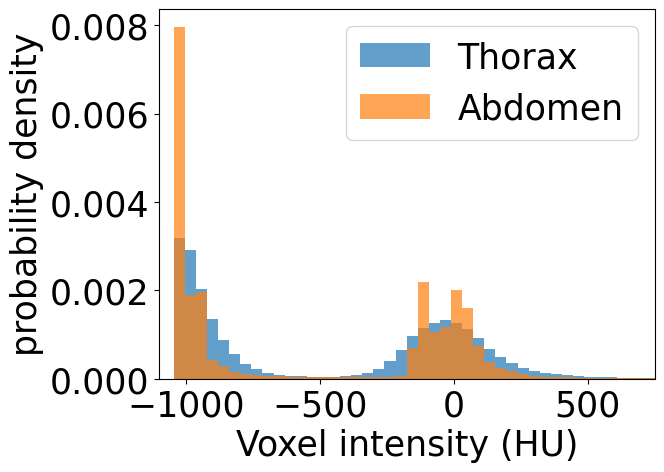

In [29]:
# Distribution (density) of images intensities
densities = {}
for path in [path_to_image_densities_train, path_to_image_densities_test]:
    densities.update(np.load(path, allow_pickle=True).item())
grouped_densities = {"Thorax": [], "Abdomen": []}
series_df.set_index('uuid', inplace=True)
for fname, value in densities.items():
    uuid = fname.split('.nii.gz')[0]
    region = series_df.loc[uuid, 'series_region']
    grouped_densities[region].append({"filename": fname, **value})
series_df.reset_index(inplace=True)
mean_densities = {
    region: {
        "density": np.mean(np.concatenate([subitem["density"].reshape(-1,1) for subitem in item], axis=1), axis=1),
        "bins": item[-1]["bins"]
    }
    for region, item in grouped_densities.items()
}
# Plot
for region in mean_densities.keys():
    plt.bar(
        mean_densities[region]["bins"][:-1],
        mean_densities[region]["density"],
        width=np.diff(mean_densities[region]["bins"]),
        alpha=0.7,
        label=region
    )
plt.xlabel('Voxel intensity (HU)')
plt.ylabel('probability density')
plt.title('Distribution of CT images Voxel Intensities')
plt.xlim((-1100, 750))
plt.legend()
if savefig:
    if not add_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'voxel_intensities_distribution.svg', bbox_inches='tight', transparent=True)
plt.show()